In [350]:
# imports
import pandas as pd # For dataframe management
import numpy as np # For creating ranges and random numbers
import matplotlib.pyplot as plt # Used with geopandas to plot maps
import random # Random number generator
import geopandas as gpd # For working with geospatial data
from geopandas import GeoSeries as gs # ^^^
from shapely.geometry import Polygon, LineString, Point # ^^^
from shapely.ops import nearest_points # ^^^
from sklearn import preprocessing # Scales data
from sklearn.model_selection import train_test_split # For training/testing OLS model
import statsmodels.api as sm # Creates OLS model
from sklearn.metrics import (confusion_matrix, accuracy_score) # Gauge accuracy
import streamlit as st # For deployment
import folium
from streamlit_folium import folium_static # ^^^

In order to identify biases in urban planning and social inequities within the
city of Montréal, the following study suggests factors which might predict whether a resident is likely to have high-quality green spaces near their homes.

The purpose of this project is to build a model for predicting how close an individual is to a major park in the city based on trends revealed by averages in the individual’s census tract. Had no features stood out as being predictive of a disparity in access to major parks, I would have concluded that the municipalities on the Island of Montréal had succeeded in making green space universally-accessible. However, as the following research makes clear, there are indeed socioeconomic factors which are reliable indicators of whether people are in close proximity to one of Montréal's 'grand parcs'.

## Find and sort data from Montreal Census Tracts

Metrics of interest:

- Age
- Household Size
- Household Income
- Language spoken most often at home
- Education
- Highest certificate, diploma or degree (level of education)
- Ethnic origin OR visible minority population
- Indigenous status
- Immigrant status
- Citizenship

In [2]:
metrics = [
    'Average age of the population', 'Average Household Size', 
    'Total - Language spoken most often at home for the total population excluding institutional residents - 100% data',
    'English', 'French', 'Non-official languages', 
    'Average after-tax income of households in 2015 ($)', 
    'Total - Citizenship for the population in private households - 25% sample data',
    'Not Canadian citizens',
    'Total - Immigrant status and period of immigration for the population in private households - 25% sample data',
    'Immigrants',
    'Total - Aboriginal identity for the population in private households - 25% sample data',
    'Aboriginal identity', 
    'Total - Visible minority for the population in private households - 25% sample data',
    'Total visible minority population',
    'Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data',
    'No certificate, diploma or degree',
    'Secondary (high) school diploma or equivalency certificate',
    'Postsecondary certificate, diploma or degree'
          ]

In [3]:
# Create DataFrame with coordinates to relevant data
df_guide = pd.read_csv('./data/Census Tract Rows.csv')

# Find Montreal Geo Code
geo = str(int(df_guide['Geo Code'].where(df_guide['Geo Name'] == 'Montréal').dropna()))

# Drop all rows without Montreal Geo Code

checking = True

for i in range(len(df_guide)):
    # Check first 3 digits are MTL geo code
    if str(df_guide.loc[i][0])[:3] != geo or checking == False: 
        df_guide.drop([i], inplace = True)
    elif '4620625' in str(df_guide.loc[i][0]): # Limit to CT's on Island of Montreal
        df_guide.drop([i], inplace = True)
        checking = False
        
# Record first and last rows of MTL-specific data
start = df_guide.iloc[0][2]
end = df_guide.iloc[-1][2]

# Create df with all census tract data
df = pd.read_csv('./data/Census Tracts.csv')[start:end]

# Export to csv (uncomment to save)
# df.to_csv('./data/Montreal Census Tracts.csv')

# Create new df and change column names
df_total = df[['GEO_CODE (POR)', 
          'DIM: Profile of Census Tracts (2247)', 
          'Dim: Sex (3): Member ID: [1]: Total - Sex']]
df_total.rename(columns =
      {'GEO_CODE (POR)':
       'Census Tract',
       'DIM: Profile of Census Tracts (2247)':
       'Feature',
       'Dim: Sex (3): Member ID: [1]: Total - Sex':
       'Amount'},
       inplace = True
      )

df_total.reset_index(inplace=True, drop=True)

# Remove features not included in our relevant metrics list
df_total = df_total[df_total['Feature'].isin(metrics)]
df_total.reset_index(inplace = True, drop=True)

/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/211861673.py:24: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/Census Tracts.csv')[start:end]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/211861673.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total.rename(columns =


In [4]:
# Get index positions of relevant metrics
lang_ids = list(df_total[df_total['Feature'] == 'Total - Language spoken most often at home for the total population excluding institutional residents - 100% data'].index)
edu_ids = list(df_total[df_total['Feature'] == 'Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data'].index)

def set_langs(langs):
    """Replaces the language features we are going to keep"""
    for i in lang_ids:
        df_total['Feature'][i+1] = langs[0]
        df_total['Feature'][i+2] = langs[1]
        df_total['Feature'][i+3] = langs[2]
        
def set_edu(edu):
    """Replaces the educational attainment features we are going to keep"""
    for i in edu_ids:
        df_total['Feature'][i+1] = edu[0]
        df_total['Feature'][i+2] = edu[1]
        df_total['Feature'][i+3] = edu[2]
    

In [5]:
# Manipulate DataFrame to remove irrelevant language/education figures, keeping those
# tied to the metrics we are actually interested in

# Give features placeholder names
set_langs(['ENG', 'FR', 'OTHER LANG'])
set_edu(['None', 'High School', 'Post-Secondary'])

# List of real names
langs = ['English', 'French', 'Non-official languages']
edu = ['No certificate, diploma or degree', 
       'Secondary (high) school diploma or equivalency certificate',
       'Postsecondary certificate, diploma or degree']

# Drop all features with real names, as well as empty rows
df_total = df_total.drop(df_total[df_total['Feature'].isin(langs)].index |
                         df_total[df_total['Feature'].isin(edu)].index |
                         df_total[df_total['Amount'] == 'x'].index |
                         df_total[df_total['Amount'] == 'F'].index)

# Reset feature names
set_langs(langs)
set_edu(edu)

# Clean DataFrame
df_total.reset_index(inplace = True)
df_total.drop(columns = 'index', axis = 1, inplace = True)
df_total.dropna(inplace=True)

# Reformat from long to wide format
df_total = df_total.pivot(index='Census Tract', columns=['Feature'], values=['Amount'])
df_total = df_total['Amount'] # Remove dimension
df_total = df_total.apply(pd.to_numeric) # Change str numbers to floats

# Create features which measure key variables as a percentage of tract population

totals = [
    'Total - Immigrant status and period of immigration for the population in private households - 25% sample data',
    'Total - Citizenship for the population in private households - 25% sample data',
    'Total - Aboriginal identity for the population in private households - 25% sample data',
    'Total - Language spoken most often at home for the total population excluding institutional residents - 100% data',
    'Total - Visible minority for the population in private households - 25% sample data',
    'Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data'
]

df_total['Immigrants as % of Pop.'] = df_total['Immigrants'] / df_total[totals[0]]
df_total['Non-Citizens as % of Pop.'] = df_total['Not Canadian citizens'] / df_total[totals[1]]
df_total['Indigenous ID as % of Pop.'] = df_total['Aboriginal identity'] / df_total[totals[2]]
df_total['EN at home as % of Pop.'] = df_total['English'] / df_total[totals[3]]
df_total['FR at home as % of Pop.'] = df_total['French'] / df_total[totals[3]]
df_total['OTHER at home as % of Pop.'] = df_total['Non-official languages'] / df_total[totals[3]]
df_total['Visible Minority as % of Pop.'] = df_total['Total visible minority population'] / df_total[totals[4]]
df_total['No degree as % of Pop.'] = df_total['No certificate, diploma or degree'] / df_total[totals[5]]
df_total['High School as % of Pop.'] = df_total['Secondary (high) school diploma or equivalency certificate'] / df_total[totals[5]]
df_total['Post-Secondary as % of Pop.'] = df_total['Postsecondary certificate, diploma or degree'] / df_total[totals[5]]

df_total = df_total.round(2) # Round to two decimal points

# Drop redundant columns
c = ['Aboriginal identity', 'English', 'French', 'Immigrants', 'Non-official languages',
    'Not Canadian citizens', totals[0], totals[1], totals[2], totals[3], totals[4], totals[5],
    'Total visible minority population', 'No certificate, diploma or degree',
    'Secondary (high) school diploma or equivalency certificate',
    'Postsecondary certificate, diploma or degree']

df_total.drop(columns=c, axis=1, inplace=True)

# Export to csv (uncomment to save)
# df_total.to_csv('./data/Montreal Census Tracts Trimmed Data.csv')

/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+2] = langs[1]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+3] = langs[2]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+2] = langs[1]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+3] = langs[2]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+2] = langs[1]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+3] = langs[2]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+2] = edu[1]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+3] = edu[2]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+2] = edu[1]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['Feature'][i+3] = edu[2]
/var/folders/gy/psh69xfx4tvc952qwmqhq6zc0000gn/T/ipykernel_7171/4249190621.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

## Process and Visualize Geospatial Data

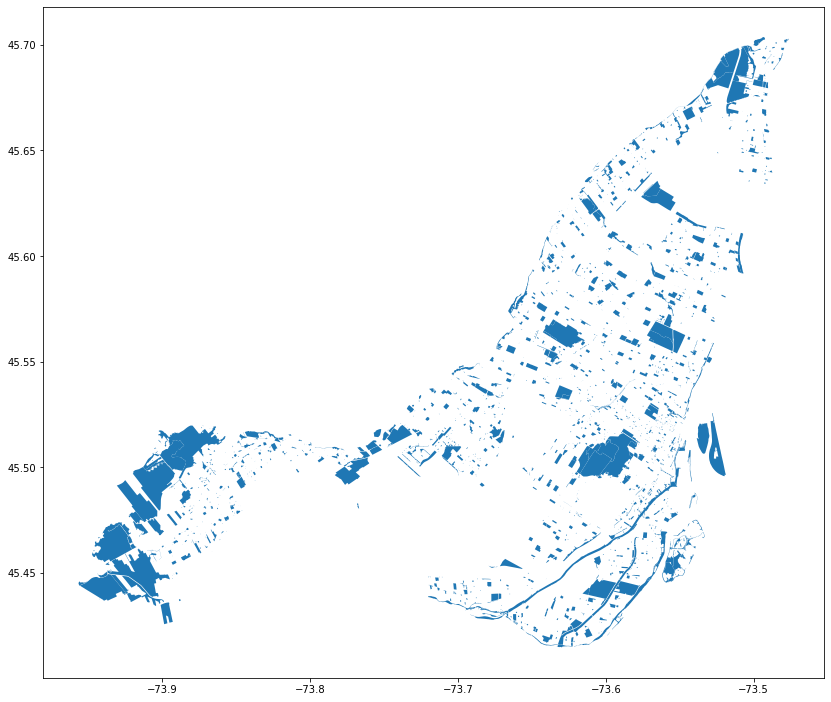

In [6]:
# All green space in Ville de Montréal (missing parks in Westmount)
gdf = gpd.read_file('./data/geo/espace_vert.json')
gdf.plot(figsize=(14,14));

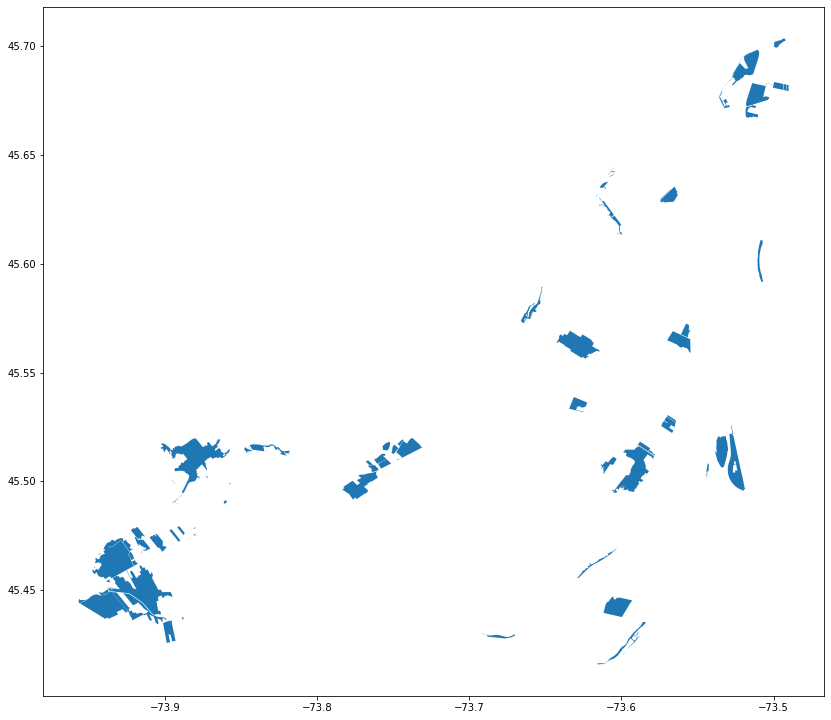

In [7]:
# Include only Montreal's large parks that are publicly-accessible
gdf = gdf[gdf.PROPRIETE == 'Ville de Montréal'].reset_index(drop=True)
gdf = gdf[gdf['TYPO1'] == 'Grand parc'].reset_index(drop=True)

gdf.plot(figsize=(14,14));

In [342]:
# Create other GeoDataFrames and import census data
df = pd.read_csv('./data/Montreal Census Tracts Trimmed Data.csv')[1:] # Census data
gdf2 = gpd.read_file('./data/geo/digit boundary/lct_000a16a_e.shp') # Census tract boundaries
gdf3 = gdf2.copy()
gdf3['geometry'] = gdf2['geometry'].centroid # Find centre of each census tract

# Convert coordinates to latitude/longitude
gdf2 = gdf2.to_crs(epsg=4326) 
gdf3 = gdf3.to_crs(epsg=4326) 

# Limit census tracts gdf to only the tracts we have data for
census_tracts = list(df['Census Tract'])

for i in range(len(gdf2)):
    if not float(gdf2.loc[i][0]) in census_tracts: 
        gdf2.drop([i], inplace = True)
        gdf3.drop([i], inplace = True)

2022-04-19 00:14:36.833 INFO    fiona.ogrext: Failed to auto identify EPSG: 7


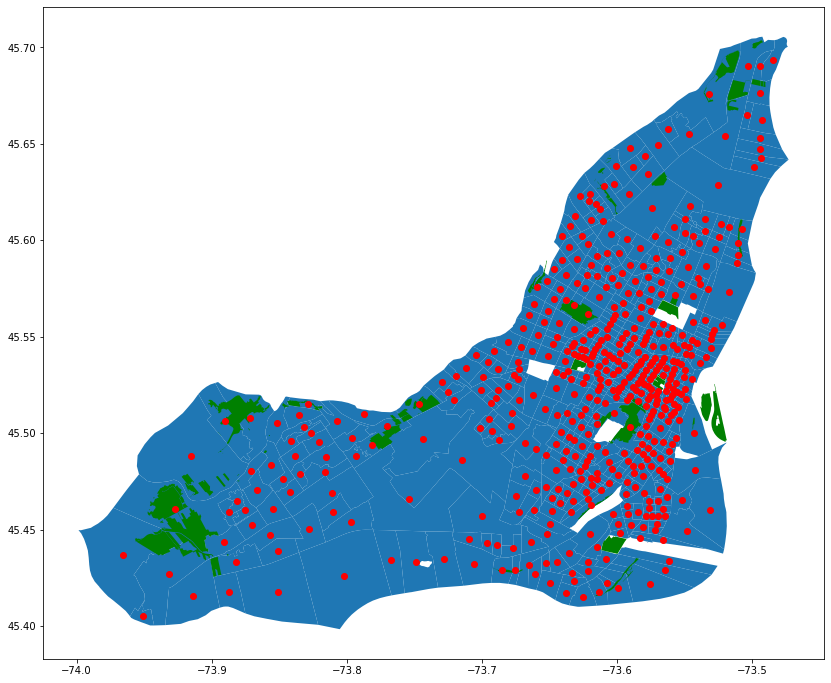

In [9]:
# Map our census tracts and the relevant parks
fig, ax = plt.subplots(figsize=(14,14))
gdf2.plot(ax=ax)
gdf.plot(ax=ax,color='green')
gdf3.plot(ax=ax,color='red')
plt.show();

In [306]:
# Sort census boundaries DataFrame by census tract
gdf2.sort_values('CTUID',inplace=True)
gdf2.reset_index(inplace=True, drop=True)

gdf3.sort_values('CTUID',inplace=True)
gdf3.reset_index(inplace=True, drop=True)

In [11]:
def get_random_point_in_tract(tract):
    """Returns a random coordinate in the given census tract area"""
    minx, miny, maxx, maxy = tract.bounds['minx'], tract.bounds['miny'], tract.bounds['maxx'], tract.bounds['maxy']
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        check = tract.contains(p)[0]
        if check == True:
            return p
        
def distance_to_park(tract):
    """Returns the average distance, in meters, between ten random points in a given census
    tract area and the nearest Grand parc"""
    
    num = 10
    distance_sum = 0
    tract = str(tract)
    
    # Add extra zero to match format in gdf3
    if len(tract) == 9:
        tract+='0'
    coord = gdf2.loc[gdf2['CTUID'] == tract]['geometry'].reset_index(drop=True)
    
    # Generate 10 random points and calculate distance
    for i in np.arange(num):
        point = gs(get_random_point_in_tract(coord))
        # EPSG 3798 is a good distance projection for Quebec--used by provincial government
        point.crs = 'EPSG:3798'
        distance_sum += point.apply(lambda x: gdf.distance(x).min())b
    
    return distance_sum/num

In [346]:
# Change geometry to give accurate measure of distance given Montréal's coordinates
gdf = gdf.to_crs(epsg=3798)
gdf2 = gdf2.to_crs(epsg=3798) 
gdf3 = gdf3.to_crs(epsg=3798) 

# Calculate average distance to park in census tract
df['Distance to Park'] = df['Census Tract'].apply(distance_to_park)

In [13]:
# Export to csv (uncomment to save)
df.to_csv('./data/Montreal Census Tracts Trimmed Data with Distance.csv')

## Create OLS Model and Assess Accuracy

In [264]:
# Get X and y data from most recent csv file
df = pd.read_csv('./data/Montreal Census Tracts Trimmed Data with Distance.csv')

# Remove CT labels
df.drop(columns=['Unnamed: 0', 'Census Tract'], inplace=True) 
names = list(df) # Feature names

df.describe()

,Average after-tax income of households in 2015 ($),Average age of the population,Immigrants as % of Pop.,Non-Citizens as % of Pop.,Indigenous ID as % of Pop.,EN at home as % of Pop.,FR at home as % of Pop.,OTHER at home as % of Pop.,Visible Minority as % of Pop.,No degree as % of Pop.,High School as % of Pop.,Post-Secondary as % of Pop.,Distance to Park,Distance Score
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,64300.300000,40.301154,0.317596,0.131058,0.007231,0.220808,0.530865,0.165000,0.302231,0.102019,0.162019,0.736212,1474.264679,1.503846
std,42586.371164,4.092227,0.133625,0.080923,0.006774,0.179302,0.238256,0.107907,0.170495,0.069304,0.056199,0.114259,987.215261,0.674319
min,26525.000000,26.300000,0.070000,0.010000,0.000000,0.010000,0.090000,0.020000,0.030000,0.000000,0.030000,0.260000,24.986274,1.000000
25%,47575.250000,37.600000,0.210000,0.080000,0.000000,0.070000,0.327500,0.080000,0.160000,0.050000,0.120000,0.660000,729.599268,1.000000
50%,54142.000000,40.000000,0.290000,0.120000,0.010000,0.170000,0.530000,0.140000,0.260000,0.090000,0.160000,0.740000,1246.019829,1.000000
75%,66327.000000,42.525000,0.410000,0.170000,0.010000,0.320000,0.750000,0.240000,0.420000,0.140000,0.200000,0.830000,1976.939662,2.000000
max,625556.000000,64.700000,0.680000,0.580000,0.030000,0.730000,0.930000,0.550000,0.870000,0.410000,0.340000,0.970000,6116.020841,4.000000


In [265]:
# Scale data
d = preprocessing.normalize(df)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.describe()

,Average after-tax income of households in 2015 ($),Average age of the population,Immigrants as % of Pop.,Non-Citizens as % of Pop.,Indigenous ID as % of Pop.,EN at home as % of Pop.,FR at home as % of Pop.,OTHER at home as % of Pop.,Visible Minority as % of Pop.,No degree as % of Pop.,High School as % of Pop.,Post-Secondary as % of Pop.,Distance to Park,Distance Score
count,520.000000,520.000000,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,520.000000,520.000000,520.000000
mean,0.999529,0.000714,5.783748e-06,2.531086e-06,1.364682e-07,3.514364e-06,9.727947e-06,3.087157e-06,5.739658e-06,2.007163e-06,2.979876e-06,0.000013,0.025570,0.000026
std,0.000595,0.000199,3.327075e-06,2.219005e-06,1.381551e-07,2.686510e-06,5.256889e-06,2.582912e-06,4.341157e-06,1.727496e-06,1.425959e-06,0.000004,0.016982,0.000013
min,0.994860,0.000066,3.387608e-07,3.985421e-08,0.000000e+00,1.375513e-07,3.197154e-07,9.963552e-08,1.840126e-07,0.000000e+00,7.970842e-08,0.000001,0.000120,0.000002
25%,0.999349,0.000603,3.294914e-06,1.206956e-06,0.000000e+00,1.304629e-06,5.263323e-06,1.233628e-06,2.673738e-06,7.447640e-07,1.894034e-06,0.000011,0.012508,0.000017
50%,0.999754,0.000729,4.923197e-06,2.008192e-06,1.558238e-07,2.951527e-06,9.855941e-06,2.254684e-06,4.342858e-06,1.692367e-06,2.957890e-06,0.000013,0.022168,0.000022
75%,0.999922,0.000835,7.710956e-06,3.223612e-06,2.051115e-07,5.010816e-06,1.399988e-05,4.325201e-06,7.554383e-06,2.695778e-06,3.848994e-06,0.000015,0.036077,0.000037
max,1.000000,0.001660,1.796178e-05,2.099983e-05,6.778072e-07,2.186289e-05,2.210914e-05,1.670926e-05,2.534462e-05,1.489304e-05,1.198708e-05,0.000035,0.101251,0.000090


In [266]:
X = df.drop(columns=['Distance to Park'], axis=1)
X = sm.add_constant(X)
y = df['Distance to Park']

est = sm.OLS(y,X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Distance to Park   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     188.3
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          3.19e-184
Time:                        21:51:55   Log-Likelihood:                -3834.2
No. Observations:                 520   AIC:                             7696.
Df Residuals:                     506   BIC:                             7756.
Df Model:                          13                                         
Covariance Type:                  HC2                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                              -3158.2908   2922.560     -1.081      0.280   -8886.403    2569.822
Average after-tax income of households in 2015 ($)    -0.0010      0.000     -2.488      0.013      -0.002      -0.000
Average age of the population                          2.4588      5.592      0.440      0.660      -8.500      13.418
Immigrants as % of Pop.                              395.2635    468.886      0.843      0.399    -523.737    1314.264
Non-Citizens as % of Pop.                           -621.5939    334.753     -1.857      0.063   -1277.697      34.509
Indigenous ID as % of Pop.                          -449.9810   3018.338     -0.149      0.881   -6365.815    5465.853
EN at home as % of Pop.                             -522.6116   1160.199     -0.450      0.652   -2796.560    1751.337
FR at home as % of Pop.                             -883.1846   1159.813     -0.761      0.446   -3156.377    1390.008
OTHER at home as % of Pop.                          -606.9002   1201.979     -0.505      0.614   -2962.737    1748.936
Visible Minority as % of Pop.                       -399.5543    267.404     -1.494      0.135    -923.657     124.548
No degree as % of Pop.                              3562.7848   2736.756      1.302      0.193   -1801.159    8926.728
High School as % of Pop.                            2716.4472   2775.136      0.979      0.328   -2722.720    8155.614
Post-Secondary as % of Pop.                         3523.3081   2728.785      1.291      0.197   -1825.012    8871.628
Distance Score                                      1304.4245     28.979     45.013      0.000    1247.628    1361.221
==============================================================================
Omnibus:                       21.066   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.851
Skew:                           0.077   Prob(JB):                      0.00726
Kurtosis:                       2.343   Cond. No.                     2.61e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 2.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

By p-value, our features with statistical-significance are:

- Income
- Citizenship
- Visible Minority Population
- Education

In [280]:
r = random.seed() # Randomize train/test split

# Feature selection
features = ['Average after-tax income of households in 2015 ($)',
            #'Immigrants as % of Pop.',
            #'Average age of the population',
            #'Indigenous ID as % of Pop.',
            'Visible Minority as % of Pop.',
            'Non-Citizens as % of Pop.',
            #'EN at home as % of Pop.',
            #'FR at home as % of Pop.',
            #'OTHER at home as % of Pop.',
            #'No degree as % of Pop.',
            #'High School as % of Pop.',
            'Post-Secondary as % of Pop.'
]

# Set X and y
X = scaled_df[features]
y = scaled_df['Distance to Park']

# Train-test split for proving model's accuracy
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = r)

# Add constant to training data
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train,X2).fit(cov_type='HC2')

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Distance to Park   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     251.5
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          1.04e-102
Time:                        21:52:21   Log-Likelihood:                 1417.9
No. Observations:                 364   AIC:                            -2826.
Df Residuals:                     359   BIC:                            -2806.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 27.3491      1.100     24.873      0.000      25.194      29.504
Average after-tax income of households in 2015 ($)   -27.3433      1.100    -24.857      0.000     -29.499     -25.187
Visible Minority as % of Pop.                        462.2583     96.800      4.775      0.000     272.534     651.983
Non-Citizens as % of Pop.                          -1263.0231    253.516     -4.982      0.000   -1759.905    -766.141
Post-Secondary as % of Pop.                          573.7065    109.461      5.241      0.000     359.167     788.246
==============================================================================
Omnibus:                       88.120   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.425
Skew:                          -1.200   Prob(JB):                     2.47e-45
Kurtosis:                       5.789   Cond. No.                     1.39e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Great R-squared value (0.916) and perfect p-values for our features gives us confidence in the model. Now to conduct accuracy test on testing data:

In [281]:
X_test = sm.add_constant(X_test) # Add constant to testing data
Y_pred = est.predict(X_test) # Generate predictions

In [282]:
Y_test

48     0.005164
425    0.026517
433    0.011651
383    0.101251
110    0.016414
         ...   
321    0.058116
473    0.028969
288    0.004815
396    0.060659
390    0.053012
Name: Distance to Park, Length: 156, dtype: float64

In [283]:
Y_pred

48     0.013515
425    0.020567
433    0.013516
383    0.155041
110    0.016259
         ...   
321    0.060030
473    0.023904
288    0.014173
396    0.063508
390    0.049534
Length: 156, dtype: float64

Because we have normalized the y-value, and because the results are continuous, we will need to scale up the results in order to interpret the model's accuracy.

In [284]:
def distance_score(distance):
    """Returns a score based on the distance to a park"""
    
    # 25th percentile; 729.599268 meters or closer
    if distance <= 0.012508:
        return 1 # Easy access to large park, ~15 min or less walk
    # 50th percentile; up to 1246.019829 meters
    elif distance <= 0.022168:
        return 2 # Good access to large park, ~20 min walk
    # 75th percentile; up to 1976.939662
    elif distance <= 0.036077:
        return 3 # Some access to large park, ~30 min plus walk, some transit likely required
    # 100th percentile; as far as 6116.020841 meters
    else:
        return 4 # Poor access to large park, ~40 min walk, transit/personal vehicle required

In [285]:
Y_test_scaled = Y_test.apply(distance_score)
Y_pred_scaled = Y_pred.apply(distance_score)

In [286]:
Y_test_scaled

48     1
425    3
433    1
383    4
110    2
      ..
321    4
473    3
288    1
396    4
390    4
Name: Distance to Park, Length: 156, dtype: int64

In [287]:
Y_pred_scaled

48     2
425    2
433    2
383    4
110    2
      ..
321    4
473    3
288    2
396    4
390    4
Length: 156, dtype: int64

In [288]:
accuracy_score(Y_test_scaled, Y_pred_scaled)

0.6666666666666666

In [289]:
confusion_matrix(Y_test_scaled, Y_pred_scaled)

array([[14, 25,  0,  0],
       [ 2, 35,  0,  0],
       [ 0, 13, 26,  0],
       [ 0,  0, 12, 29]])

With an accuracy score of ~66%, we are able to predict which quartile of large park accessibility a census tract will fit into, two times out of three.

Our confusion matrix also shows that wherever a quartile is misidentified, it is always adjascent to the correct quartile, meaning that the prediction is not far off from the data. The model does a poor job identifying census tracts in the first quartile, likely because they are so close to parks, in distance, relative to tracts in the second quartile.

## Model Analysis

In [293]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Distance to Park   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     251.5
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          1.04e-102
Time:                        21:52:52   Log-Likelihood:                 1417.9
No. Observations:                 364   AIC:                            -2826.
Df Residuals:                     359   BIC:                            -2806.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 27.3491      1.100     24.873      0.000      25.194      29.504
Average after-tax income of households in 2015 ($)   -27.3433      1.100    -24.857      0.000     -29.499     -25.187
Visible Minority as % of Pop.                        462.2583     96.800      4.775      0.000     272.534     651.983
Non-Citizens as % of Pop.                          -1263.0231    253.516     -4.982      0.000   -1759.905    -766.141
Post-Secondary as % of Pop.                          573.7065    109.461      5.241      0.000     359.167     788.246
==============================================================================
Omnibus:                       88.120   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.425
Skew:                          -1.200   Prob(JB):                     2.47e-45
Kurtosis:                       5.789   Cond. No.                     1.39e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Building this OLS Regression model has demonstrated the factors most important in determining access to major greenspace in Montréal.

The model predicts that census tracts are closer to major parks where the tract's residents make more money or where there is a higher percentage of non-citizen residents. Coversely, census tracts where residents are more likely to identify as a visible minority or to have post-secondary education are, on average, further away from parks.

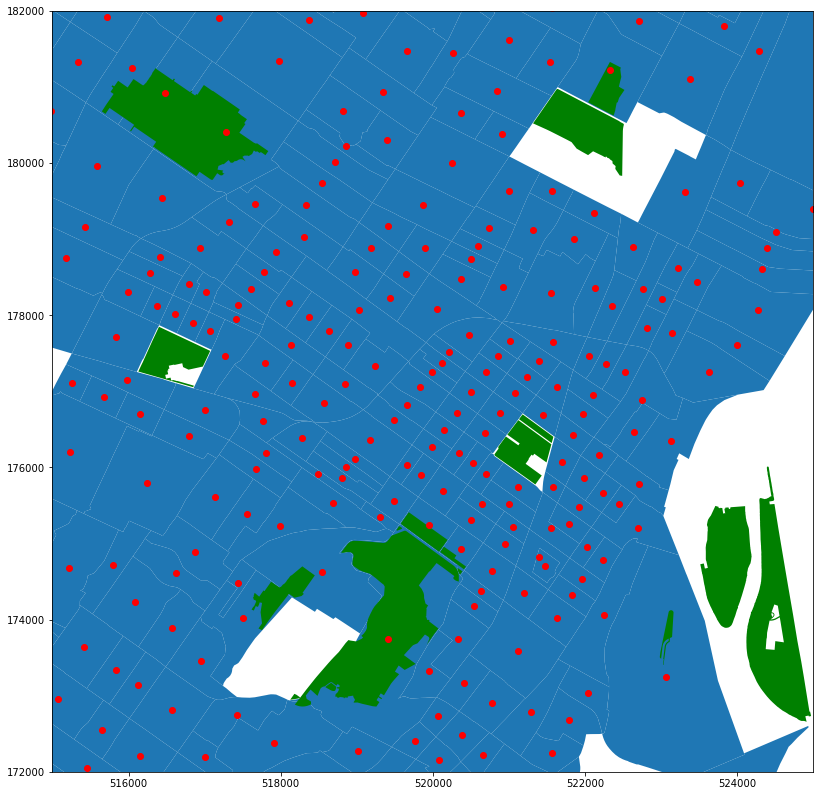

In [291]:
# Map of large parks northeast of downtown
fig, ax = plt.subplots(figsize=(14,14))
gdf2.plot(ax=ax)
gdf.plot(ax=ax,color='green')
gdf3.plot(ax=ax,color='red')
plt.ylim(172000,182000)
plt.xlim(515000,525000)
plt.show();

One explanation for the close proximity between high-income areas and the 'Grand parcs' is suggested by the high volume of census tracts clustered around Parc La Fontaine and Northeast of Mont Royal. The Plateau-Mont Royal area is an area of the city that has experienced gentrification in recent years and the rising cost of living in the area could explain why these park-rich neighbourhoods are also home to higher-income households. More broadly, the flight of the working class from North America's downtown districts into more suburban areas on the margins of cities would explain the skew of wealthier residents in the city's centre. These well-to-do downtown residents are able to enjoy better park access because of how numerous the large parks are in the more population-dense and expensive districts of the city. These findings show us that lower-income residents are underserved in Montréal in regards to accessing the large parks.

On a similar note, the high volume of non-citizens near parks is likely related to the  concentration of post-secondary institutions in the city's core as well as the number of cultural enclaves located in the area. It can be assumed that many non-citizens are in Montréal because they are studying there or because they are in the early stages of moving to Canada. In the latter case, it would make sense that these residents would be staying with friends or relatives, or at least be in close proximity to their cultural community, rather than living in an area far from the downtown with a higher number of single-family homes. It can therefore be concluded that non-citizens have adequate access to large parks as compared to other residents.

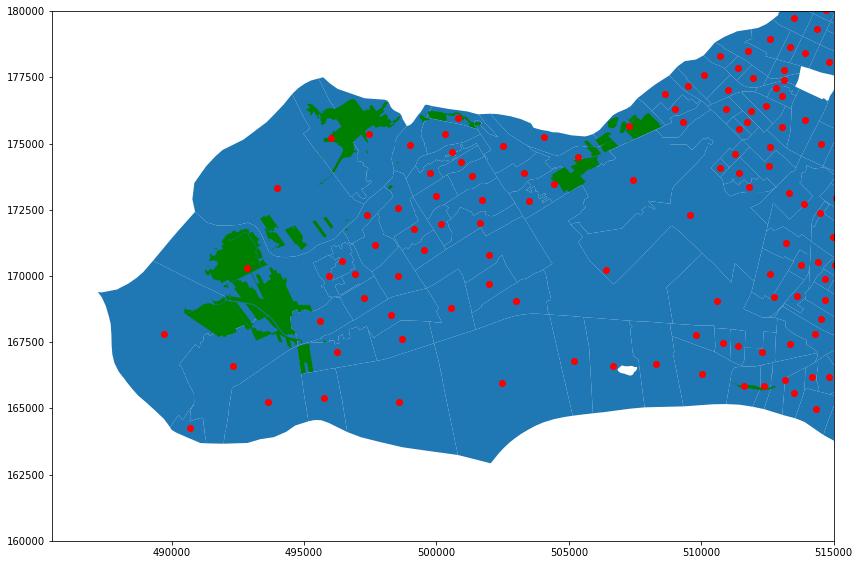

In [292]:
# Map of southwest portion of the Island of Montréal
fig, ax = plt.subplots(figsize=(14,14))
gdf2.plot(ax=ax)
gdf.plot(ax=ax,color='green')
gdf3.plot(ax=ax,color='red')
plt.ylim(160000,180000)
plt.xlim(485500,515000)
plt.show();

Inspecting the southwestern-most portion of the island suggests some explanation of why certain communities have worse access to the 'grand parcs'.

Just as the high-concentration of students living in the downtown helps explain the closeness of non-citizens to parks, it also partially explains why post-secondary graduates live farther from them. Due to the fact that most people studying at post-secondary schools lkely do not have prior post-secondary certification, it can be assumed that there are fewer graduates living in the student-heavy downtown neighbourhoods. Graduates or certified tradespeople, meanwhile, are more likely to live in suburban parts of the city with more available living space and the seclusion that people often desire as working professionals raising a family. These residents would need to rely on public transportation or a personal vehicle to access the city's large greenspaces, a tradeoff that graduates probably make because they have a car or are willing to forego using public greenspace due to having a private backyard.

Lack of access for visible minorities, meanwhile, possibly speaks to gentrifying forces in the city which make it easier for wealthy Montréalers to live in desireable neighbourhoods close to the best parks. Long-established communities with greater concentration of wealth and more homogeneity, like the town of Westmount for example, probably make it difficult for newcomers and people outside of the existing community to move in because there is not as much turnover in that area of the city.

Overall, making efforts to slow gentrification and ensuring the city core is an accessible place to live for everyone appear the best policy prescriptions for making access the 'grand parcs' more equitable.

## Deployment

In [347]:
# Reset DataFrame values
df = pd.read_csv('./data/Montreal Census Tracts Trimmed Data with Distance.csv')

In [344]:
gdf2.reset_index(inplace=True,drop=True)
gdf2

,CTUID,CTNAME,PRUID,PRNAME,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry
0,4620001.00,0001.00,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.50001 45.60937, -73.50280 45.599..."
1,4620002.00,0002.00,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.51711 45.60195, -73.51732 45.601..."
2,4620003.00,0003.00,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.52113 45.60342, -73.52152 45.602..."
3,4620004.00,0004.00,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.51875 45.59870, -73.51911 45.597..."
4,4620005.00,0005.00,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.51536 45.60346, -73.51332 45.602..."
...,...,...,...,...,...,...,...,...,...
515,4620512.03,0512.03,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.81621 45.51387, -73.81527 45.513..."
516,4620512.04,0512.04,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.84166 45.50261, -73.84301 45.502..."
517,4620515.02,0515.02,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.88290 45.46499, -73.88424 45.464..."
518,4620515.03,0515.03,24,Quebec / Québec,462,24462,Montréal,B,"POLYGON ((-73.86607 45.45997, -73.87264 45.456..."


In [354]:
df_trimmed = df[features].join(gdf2['CTUID']).join(df['Distance to Park']).join(gdf2['geometry'])
df_trimmed = gpd.GeoDataFrame(df_trimmed)

,Average after-tax income of households in 2015 ($),Visible Minority as % of Pop.,Non-Citizens as % of Pop.,Post-Secondary as % of Pop.,CTUID,Distance to Park,geometry
0,53064.0,0.15,0.03,0.64,4620001.00,209.836989,"POLYGON ((-73.50001 45.60937, -73.50280 45.599..."
1,47767.0,0.17,0.03,0.61,4620002.00,518.387951,"POLYGON ((-73.51711 45.60195, -73.51732 45.601..."
2,51760.0,0.22,0.07,0.61,4620003.00,1118.107881,"POLYGON ((-73.52113 45.60342, -73.52152 45.602..."
3,51154.0,0.15,0.05,0.61,4620004.00,979.729172,"POLYGON ((-73.51875 45.59870, -73.51911 45.597..."
4,49358.0,0.14,0.05,0.61,4620005.00,296.531254,"POLYGON ((-73.51536 45.60346, -73.51332 45.602..."
...,...,...,...,...,...,...,...
515,46466.0,0.54,0.16,0.57,4620512.03,772.997303,"POLYGON ((-73.81621 45.51387, -73.81527 45.513..."
516,45150.0,0.59,0.16,0.57,4620512.04,1545.698818,"POLYGON ((-73.84166 45.50261, -73.84301 45.502..."
517,55499.0,0.41,0.13,0.61,4620515.02,1971.505672,"POLYGON ((-73.88290 45.46499, -73.88424 45.464..."
518,52951.0,0.40,0.07,0.63,4620515.03,2375.025717,"POLYGON ((-73.86607 45.45997, -73.87264 45.456..."


In [357]:
# Set configuration of deployment page
st.set_page_config(layout="wide")

m = folium.Map(location = [45.48, -73.56], tiles='CartoDB positron', name='Light Map',
              zoom_start=11, attr='My Data attribution')

feature_selected = st.selectbox("Choose feature", features)

# Map census tracts with feature data
folium.Choropleth(
    geo_data=gdf2,
    name='choropleth',
    data=df_trimmed,
    columns=['CTUID', feature_selected],
    key_on='feature.properties.CTUID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.1,
    legend_name=feature_selected
).add_to(m)

# Add parks
folium.GeoJson(
    data=gdf,
).add_to(m)

# Add popup windows for each CT
pop = folium.features.GeoJsonPopup(fields=['CTUID','Distance to Park'])

folium.features.GeoJson(    
    data=df_trimmed,
    name='Census Tracts',
    popup=pop,
    overlay=False,
    show=False
).add_to(m)

# Deploy
folium_static(m, width=1600, height=950)


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)